In [4]:
import numpy as np
import pylab as plt
import matplotlib
import pyLikelihood
import os
import glob 
from fermipy.gtanalysis import GTAnalysis
from fermipy.plotting import ROIPlotter, SEDPlotter
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.optimize import minimize_scalar
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from fermipy import utils

## 1- Importando os dados de maneira inteligente

In [5]:
# Vou utilizar dados de P8R2 para 6 e 14 anos
list_lnl_14years_P8R2 = glob.glob('eflux_and_loglikes_files/P8R2_14Years_files/*_Dloglikes_14years_P8R2.txt')
list_lnl_6years_P8R2 = glob.glob('eflux_and_loglikes_files/P8R2_6years_Files/*_Dloglikes_6years_P8R2.txt')

#-----------------------------------------#
list_eflux_14years_P8R2 = glob.glob('eflux_and_loglikes_files/P8R2_14Years_files/*_eflux_14years_P8R2.txt')
list_eflux_6years_P8R2  = glob.glob('eflux_and_loglikes_files/P8R2_6years_Files/*_eflux_6years_P8R2.txt*')

#criando lista de Jfactor

Jfactor_array = np.array([18.2,17.6,17.9,19.0,18.8,17.8,16.9,18.0,16.3,18.5,19.4,17.5,19.4,18.9,18.9])

# criando Lista de likefiles
list_likefile = glob.glob('likes_files/like_*')

# Demais dados
specfile = 'spectrum_bbbar_100GeV.txt' # Esse txt conseguir em um dos primeiros artigos do fermi
crossesctions = np.loadtxt('limits_bb.txt',unpack=True)

### 1.1 Definindo variaveis para funcionalidade do código

In [47]:
data = np.loadtxt(list_likefile[0], unpack=True)
emins, emaxs = np.unique(data[0]),np.unique(data[1])
ebin = np.sqrt(emins*emaxs)
efluxes = data[2].reshape(len(emins),-1)
logLikes = data[3].reshape(len(emins),-1)
Spectrum =np.loadtxt(specfile,unpack=True)
mass = crossesctions[0]
sigmav0 = 1e-25
delta =2.71

lista_de_nomes = ['Bootes','Canes_Venatici II','Carina','Coma_Berenices','Draco',
                  'Fornax','Hercules','Leo_II','Leo_IV','Sculptor','Segue_I','Sextans',
                  'Ursa_Major_II','Ursa Minor','Willma_1']  

lista_de_nomes_old = ['Bootes_I','Canes','Carina', 'Coma','Draco','Fornax','Hercules','Leo_II','Leo_IV','Sculptor','Segue_1',
                     'Sextans','Ursa_Major_II','Ursa_Minor','Wilma']
# Esse norm_scan é meio artistico de conseguir reproduzi-lo
norm_scan = np.loadtxt('norm_scan.txt')

In [56]:
x

10

# Estrutura física do códido

In [14]:
def eflux(spectrum, emin=1e2, emax=1e5, quiet=False):
    """ Integrate a generic spectrum, multiplied by E, to get the energy flux.
    """
    espectrum = lambda e: spectrum(e)*e
    tol = min(espectrum(emin),espectrum(emax))*1e-10
    try:
        return quad(espectrum,emin,emax,epsabs=tol,full_output=True)[0]
    except (Exception, msg):
        print('Numerical error "%s" when calculating integral flux.' % msg)
        return np.nan
# Keep numpy from complaining about dN/dE = 0...

In [57]:
for i in range(len(Jfactor_array)):
    efluxes= np.loadtxt(list_eflux_6years_P8R2[i])
    dlog= np.loadtxt(list_lnl_6years_P8R2[i])
    lnl_fermi_scan = np.zeros((21,7000))
    jfactor_fermi   = Jfactor_array[i]
    j0_fermi      = jfactor_fermi
    k=0
    for m in mass:
        dmf = pyLikelihood.DMFitFunction()
        dmf.readFunction(os.path.expandvars('$FERMIPY_ROOT/data/gammamc_dif.dat'))
        dmf.setParam('norm',10**Jfactor_array[i])
        dmf.setParam('sigmav',1E-25)
        dmf.setParam('mass',m)
        dmf.setParam('bratio',1.0)
        dmf.setParam('channel0',4)
    
        energy = Spectrum[0] 
        dnde = np.zeros(energy.shape)
        for j in range(len(energy)):
            dnde[j] = dmf(pyLikelihood.dArg(energy[j]))
        
        log_energy = np.log10(energy)# Transforma energia para log
        log_dnde = np.log10(dnde)# Transforma Espectro para log
        log_interp = interp1d(log_energy,log_dnde) # Cria função de Interpolação entre energia e espectro
        spectrum = lambda e: np.nan_to_num(10**( log_interp(np.log10(e)) ))# Retorna um Valor de dn/de para um valor de energia
    
        #print(eflux.shape,dlog.shape)
        pred = np.array([eflux(spectrum,e1,e2) for e1,e2 in zip(emins,emaxs)])  # Retorna o Eflux esperado por Bin
        likes = [ interp1d(f,l-l.max(), fill_value='extrapolate') for f,l in zip(efluxes,dlog)] 
        like = lambda c: sum([lnlfn(c*p) for lnlfn,p in zip(likes,pred)])
    
        norms = norm_scan[k]
    
        lnl_fermi = np.array([like(n) for n in norms])
        lnl_fermi_scan[k] =lnl_fermi
        lnl_fermi_normalizada = lnl_fermi -lnl_fermi.max()
    
        print(lnl_fermi_normalizada.shape, m)
        sigmav = j0_fermi/jfactor_fermi * sigmav0 * norms
        #crossection_scan_P8R3[k] =sigmav
        mle = np.argmax(lnl_fermi_normalizada)
        lnlfn = interp1d(lnl_fermi_normalizada[mle:],sigmav[mle:])
        delta = 2.71/2
        limit = lnlfn(-delta)
        #crossection_mass_P8R3[k] = float(limit)
        k= k+1
        print(k)
    np.savetxt('New_cross_and_loglikes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_'+lista_de_nomes[i],lnl_fermi_scan)


/tmp/ipykernel_186/266985926.py:23: RuntimeWarning: divide by zero encountered in log10
  log_dnde = np.log10(dnde)# Transforma Espectro para log


(7000,) 6.0
1
(7000,) 7.746
2
(7000,) 10.0
3
(7000,) 15.81
4
(7000,) 25.0
5
(7000,) 35.36
6
(7000,) 50.0
7
(7000,) 70.7
8
(7000,) 100.0
9
(7000,) 158.1
10
(7000,) 250.0
11
(7000,) 353.6
12
(7000,) 500.0
13
(7000,) 707.0
14
(7000,) 1000.0
15
(7000,) 1581.0
16
(7000,) 2500.0
17
(7000,) 3536.0
18
(7000,) 5000.0
19
(7000,) 7070.0
20
(7000,) 10000.0
21
(7000,) 6.0
1
(7000,) 7.746
2
(7000,) 10.0
3
(7000,) 15.81
4
(7000,) 25.0
5
(7000,) 35.36
6
(7000,) 50.0
7
(7000,) 70.7
8
(7000,) 100.0
9
(7000,) 158.1
10
(7000,) 250.0
11
(7000,) 353.6
12
(7000,) 500.0
13
(7000,) 707.0
14
(7000,) 1000.0
15
(7000,) 1581.0
16
(7000,) 2500.0
17
(7000,) 3536.0
18
(7000,) 5000.0
19
(7000,) 7070.0
20
(7000,) 10000.0
21
(7000,) 6.0
1
(7000,) 7.746
2
(7000,) 10.0
3
(7000,) 15.81
4
(7000,) 25.0
5
(7000,) 35.36
6
(7000,) 50.0
7
(7000,) 70.7
8
(7000,) 100.0
9
(7000,) 158.1
10
(7000,) 250.0
11
(7000,) 353.6
12
(7000,) 500.0
13
(7000,) 707.0
14
(7000,) 1000.0
15
(7000,) 1581.0
16
(7000,) 2500.0
17
(7000,) 3536.0
18
(7000

In [53]:
lnl_old_list =glob.glob('Crossections_and_loglkes_files/Upper_limits_14years_P8R2//lnl_fermi_scan_*')
crossection_old_list = glob.glob('Crossections_and_loglkes_files/Upper_limits_14years_P8R2/crossection_mass_*')

## Fazendo os plots, para verificar se as curvas estão consistentes com o metodo anterior

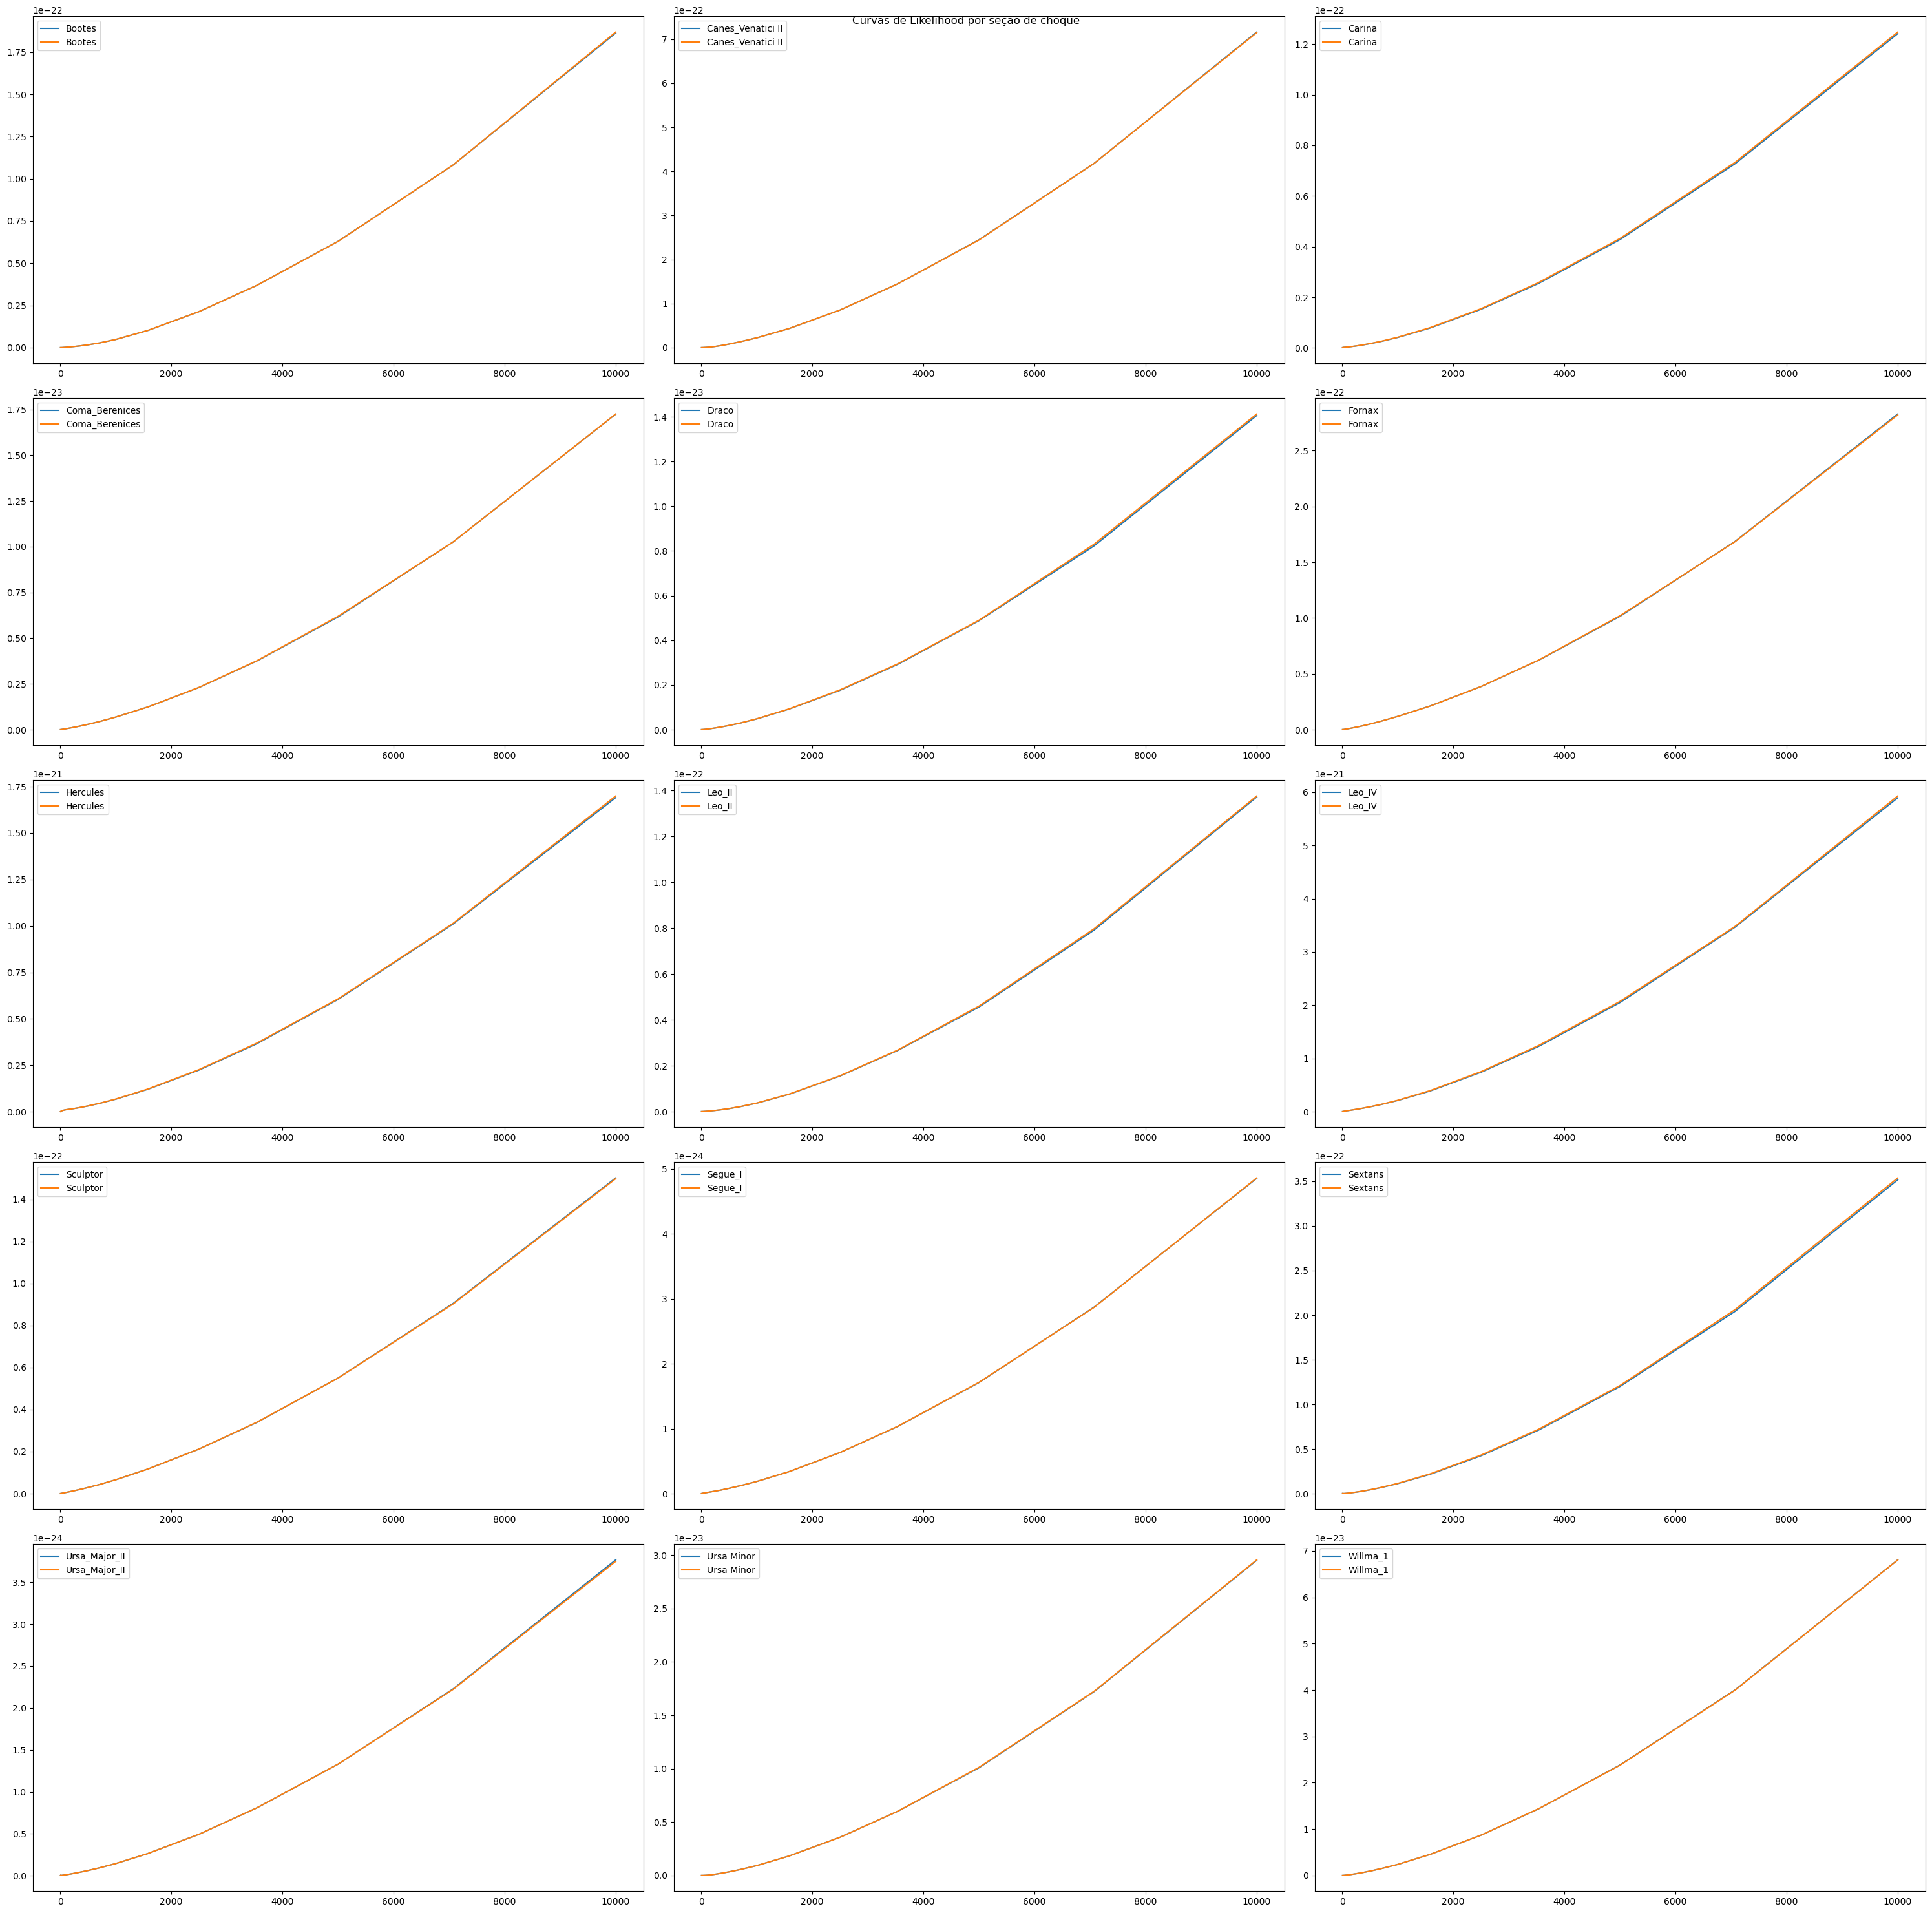

In [54]:
plt.figure(figsize=(30, 30))
crossection_new_method = np.loadtxt('crossection_scan')
crossection_14years_new_method = np.zeros(len(mass))
crossection_14years_old_mehtod = np.zeros(len(mass))
for i, name in enumerate(lista_de_nomes):
    ax = plt.subplot(5,3,i+1)
    lnl = np.loadtxt('New_cross_and_loglikes_files/Upper_limits_14years_P8R2/lnl_fermi_scan_'+lista_de_nomes[i])
    lnl_old =np.loadtxt(lnl_old_list[i])
    crossection_old =np.loadtxt(crossection_old_list[i])
    for j in range(len(mass)):
        crossection_14years_new_method[j] = utils.get_parameter_limits(crossection_new_method[j],lnl[j])['ul']
        crossection_14years_old_mehtod[j] = utils.get_parameter_limits(crossection_old[j],lnl_old[j])['ul']
    plt.plot(mass,crossection_14years_new_method, label = lista_de_nomes[i])
    plt.plot(mass,crossection_14years_old_mehtod,label = lista_de_nomes[i])
    plt.legend()
plt.suptitle('Curvas de Likelihood por seção de choque')   
plt.tight_layout() 

In [43]:
crossection_14years_new_method

array([4.40550540e-27, 4.52814646e-27, 5.28890140e-27, 8.98478313e-27,
       1.85703827e-26, 2.99110495e-26, 4.76338123e-26, 7.36843664e-26,
       1.15889436e-25, 2.07933780e-25, 3.75957766e-25, 5.91711226e-25,
       9.33269903e-25, 1.49106511e-24, 2.37901601e-24, 4.54086878e-24,
       8.69347948e-24, 1.43730994e-23, 2.38209085e-23, 4.00147713e-23,
       6.80873422e-23])

In [32]:
crossection_new_method = np.loadtxt('crossection_scan')


In [46]:
glob.glob('Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_*')

['Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Bootes_I.txt',
 'Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Canes.txt',
 'Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Carina.txt',
 'Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Coma.txt',
 'Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Draco.txt',
 'Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Fornax.txt',
 'Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Hercules.txt',
 'Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Leo_II.txt',
 'Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Leo_IV.txt',
 'Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Sculptor.txt',
 'Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Segue_1.txt',
 'Crossections_and_loglkes_files/Upper_limits_6year

In [ ]:
lnl_fermi_normalizada.shape

six_years_P8R2 =  np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R2/crossection_mass_Carina.txt')
six_years_P8R3 =  np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R3/crossection_mass_Carina.txt')
lnl_six_years_P8R2 = np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Carina.txt')
lnl_six_years_P8R3 = np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R3/lnl_fermi_scan_Carina.txt')

Crossection_P8R2 = np.zeros(len(crossection_mass_P8R3))
Crossection_P8R3 = np.zeros(len(crossection_mass_P8R3))
for i in range(len(six_years_P8R2)):
    Crossection_P8R2[i] = utils.get_parameter_limits(six_years_P8R2[i],lnl_six_years_P8R2[i])['ul']
    Crossection_P8R3[i] = utils.get_parameter_limits(six_years_P8R3[i],lnl_six_years_P8R3[i])['ul']

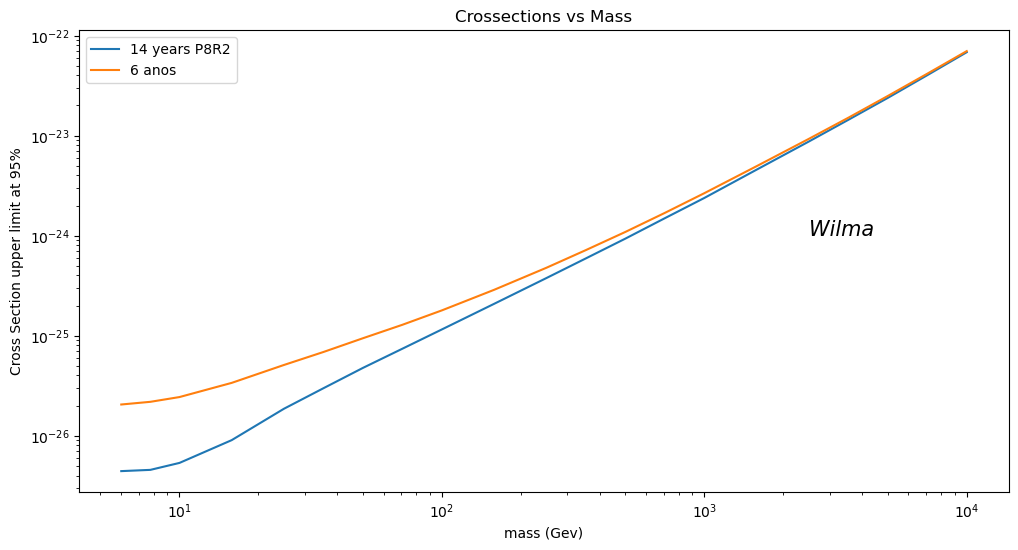

In [14]:
fig =plt.figure(figsize=(12,6))
#plt.plot(mass,Crossection_P8R2,label= 'six_years_P8R2')
#plt.plot(mass,Crossection_P8R3, label = 'six_years_P8R3')
plt.plot(mass,crossection_mass_P8R2, label = '14 years P8R2')
plt.plot(mass,crossection_mass_P8R3, label = '6 anos ')
#plt.plot(mass,crossesctions[36], label = 'Arxiv :1611 - Fermi 2015')
#plt.plot(mass,crossection_mass_Fermi, label ='Arxiv :1611 - Fermi 2015 without J factor')
plt.xlabel('mass (Gev)')
plt.ylabel('Cross Section upper limit at 95%')
plt.title('Crossections vs Mass')
plt.xscale('log')
plt.yscale('log')
plt.text(2.5e3,1e-24,'Wilma', style='oblique',fontsize='15')
plt.legend()

In [ ]:
np.savetxt('Crossections_and_loglkes_files/Upper_limits_14years_P8R2/lnl_fermi_scan_Sculptor.txt',lnl_fermi_scan_P8R2)
np.savetxt('Crossections_and_loglkes_files/Upper_limits_14years_P8R2/crossection_mass_Sculptor.txt',crossection_scan_P8R2)

In [ ]:
np.savetxt('14anos_scan',crossection_scan_P8R3)
np.savetxt('6anos_scan',crossection_scan_P8R2)

In [ ]:
Crossection_P8R3 = np.zeros(len(crossection_mass_P8R3))
for i in range(len(six_years_P8R2)):
    print(utils.get_parameter_limits(six_years_P8R2[i],lnl_six_years_P8R2[i]))

In [ ]:
crossection_scan_P8R3/crossection_scan_P8R2

In [ ]:
#precis verificar a consitencia desses dados agora

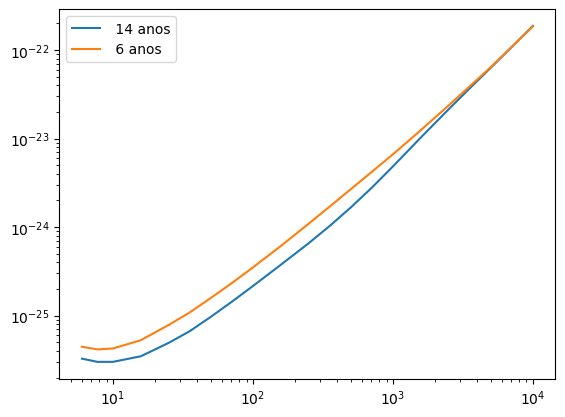

In [97]:
mass = np.loadtxt('limits_bb.txt',unpack=True)[0]

crossection_scan_14years = np.loadtxt('Crossections_and_loglkes_files/Upper_limits_14years_P8R2/crossection_mass_Bootes.txt')
crossection_scan_6years = np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R2/crossection_mass_Bootes_I.txt')
for j in range(len(crossection_scan_14years)):
    crossection_upper_limit_14years[j] = utils.get_parameter_limits(crossection_scan_14years[j],np.loadtxt('Crossections_and_loglkes_files/Upper_limits_14years_P8R2/lnl_fermi_scan_Bootes.txt')[j])['ul']
    crossection_upper_limit_6years[j]  =utils.get_parameter_limits(crossection_scan_6years[j],np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Bootes_I.txt')[j])['ul']
    #ax = plt.subplot(5,3,i+1)    
plt.plot(mass,crossection_upper_limit_14years, label = " 14 anos")
plt.plot(mass,crossection_upper_limit_6years,  label = " 6 anos")
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [98]:
crossection_mass_P8R3/crossection_upper_limit_6years

array([1.00176054, 0.99458685, 0.99843789, 0.99264917, 0.99259703,
       0.99574683, 0.99515014, 0.99506306, 0.99424815, 1.00002245,
       0.99956228, 0.99676045, 0.99950669, 1.00049195, 1.00032678,
       1.00142037, 1.00135731, 1.00180787, 1.01039337, 1.00545045,
       1.00388871])

In [94]:
eflux_6years = np.loadtxt('eflux_and_loglikes_files/P8R2_6years_Files/Bootes_eflux_6years_P8R2.txt')
dlog_6years  = np.loadtxt('eflux_and_loglikes_files/P8R2_6years_Files/Bootes_Dloglikes_6years_P8R2.txt')
norm_scan = np.loadtxt('norm_scan.txt')

In [95]:
crossection_mass_P8R3 = np.zeros(len(mass))
lnl_fermi_scan_P8R3 = np.zeros((len(mass),7000))
crossection_scan_P8R3= np.zeros(lnl_fermi_scan_P8R3.shape)
k =0
for i in mass:
    dmf = pyLikelihood.DMFitFunction()
    dmf.readFunction(os.path.expandvars('$FERMIPY_ROOT/data/gammamc_dif.dat'))
    dmf.setParam('norm',10**18.2)
    dmf.setParam('sigmav',1E-25)
    dmf.setParam('mass',i)
    dmf.setParam('bratio',1.0)
    dmf.setParam('channel0',4)   


    energy = Spectrum[0] 
    dnde = np.zeros(energy.shape)
    for j in range(len(energy)):
        dnde[j] = dmf(pyLikelihood.dArg(energy[j]))
    
    log_energy = np.log10(energy)# Transforma energia para log
    log_dnde = np.log10(dnde)# Transforma Espectro para log
    log_interp = interp1d(log_energy,log_dnde) # Cria função de Interpolação entre energia e espectro
    spectrum = lambda e: np.nan_to_num(10**( log_interp(np.log10(e)) ))# Retorna um Valor de dn/de para um valor de energia
    
    pred = np.array([eflux(spectrum,e1,e2) for e1,e2 in zip(emins,emaxs)])  # Retorna o Eflux esperado por Bin
    likes = [ interp1d(f,l-l.max(), fill_value='extrapolate') for f,l in zip(eflux_6years,dlog_6years)] 
    like = lambda c: sum([lnlfn(c*p) for lnlfn,p in zip(likes,pred)])
    
    
    norm0 = efluxes[efluxes>0].min() / pred.max() # Cria um valor de normalização
    #norms = norm0 * x # normaliza o scan range 
    #x_min =3.86552773e-01
    #x_max = 2.73532411e+08
    #norms = np.logspace(np.log10(x_min),np.log10(x_max),5000)
    norms = norm_scan[k]
    lnl_fermi = np.array([like(n) for n in norms])
    lnl_fermi_scan_P8R3[k] =lnl_fermi
    lnl_fermi_normalizada = lnl_fermi -lnl_fermi.max()
    
    # Convert global log-likelihood back into physical units
    sigmav = j0_fermi/jfactor_fermi * sigmav0 * norms
    crossection_scan_P8R3[k] =sigmav
    mle = np.argmax(lnl_fermi_normalizada)
    lnlfn = interp1d(lnl_fermi_normalizada[mle:],sigmav[mle:])
    delta = 2.71/2
    limit = lnlfn(-delta)
    crossection_mass_P8R3[k] = float(limit)
    k= k+1  
    

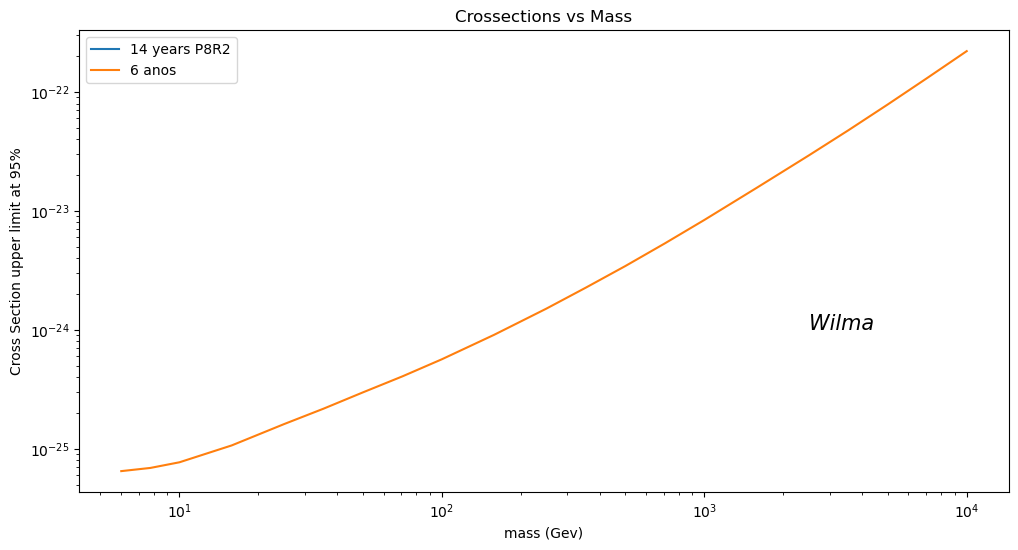

In [77]:
fig =plt.figure(figsize=(12,6))
#plt.plot(mass,Crossection_P8R2,label= 'six_years_P8R2')
#plt.plot(mass,Crossection_P8R3, label = 'six_years_P8R3')
plt.plot(mass,crossection_mass_P8R2, label = '14 years P8R2')
plt.plot(mass,crossection_mass_P8R3, label = '6 anos ')
#plt.plot(mass,crossesctions[36], label = 'Arxiv :1611 - Fermi 2015')
#plt.plot(mass,crossection_mass_Fermi, label ='Arxiv :1611 - Fermi 2015 without J factor')
plt.xlabel('mass (Gev)')
plt.ylabel('Cross Section upper limit at 95%')
plt.title('Crossections vs Mass')
plt.xscale('log')
plt.yscale('log')
plt.text(2.5e3,1e-24,'Wilma', style='oblique',fontsize='15')
plt.legend()

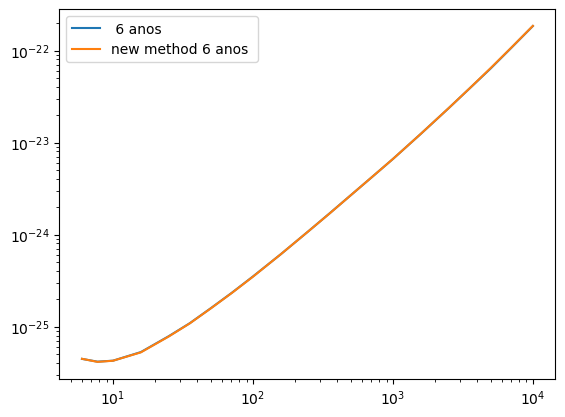

In [100]:
mass = np.loadtxt('limits_bb.txt',unpack=True)[0]

crossection_scan_14years = np.loadtxt('Crossections_and_loglkes_files/Upper_limits_14years_P8R2/crossection_mass_Bootes.txt')
crossection_scan_6years = np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R2/crossection_mass_Bootes_I.txt')
for j in range(len(crossection_scan_14years)):
    crossection_upper_limit_14years[j] = utils.get_parameter_limits(crossection_scan_14years[j],np.loadtxt('Crossections_and_loglkes_files/Upper_limits_14years_P8R2/lnl_fermi_scan_Bootes.txt')[j])['ul']
    crossection_upper_limit_6years[j]  =utils.get_parameter_limits(crossection_scan_6years[j],np.loadtxt('Crossections_and_loglkes_files/Upper_limits_6years_P8R2/lnl_fermi_scan_Bootes_I.txt')[j])['ul']
    #ax = plt.subplot(5,3,i+1)    
#plt.plot(mass,crossection_upper_limit_14years, label = " 14 anos")
plt.plot(mass,crossection_upper_limit_6years,  label = " 6 anos")
plt.plot(mass,crossection_mass_P8R3, label = 'new method 6 anos ')
plt.xscale('log')
plt.yscale('log')
plt.legend()